In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from quetzal.model import stepmodel


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
# Load the model with LoS tables from the last exercise
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'los_tables')

## Step trip generation
In every zone we need to generate a column `emission` and `attraction`. What kind of trips you count to it largely affects the interpretability of your results. If you use employment characteristics only for attraction, your model will only be applicable to commuting questions, but not for shopping or leisure trips. Moreover, the results of a congestion analysis after the assignment step are worthless because the real network load is higher when you consider all demand segments.

In [3]:
# Lets see what data we have
sm.zones.sample()

,area,emp,emp_dens,id,name,pop,pop_dens,geometry
index,,,,,,,,
zone_104,541591.60477,9449.69032,17448,106,106,25993.147479,47994,"POLYGON ((2.39967 48.87552, 2.39981 48.87423, ..."


<AxesSubplot:>

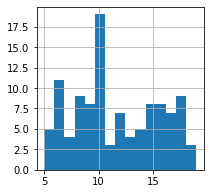

In [4]:
# Let's add the number of shops per zone to add at least this travel purpose
# Use random numbers for the toy model. Normally we would use land use data
# from OpenStreetMap (tutorials available)
# POI = point of interest
sm.zones['POIs'] = np.random.randint(5, 20, len(sm.zones))
# Check the distribution
sm.zones['POIs'].hist(bins=15, figsize=(3,3))

In [5]:
# Start with emission and attraction from commuting purposes
# Assumptions (usually derived from a mobility survey):
employment_rate = 0.7
home_office_rate = 0.1
work_trips_per_day = 1.05 # we set up the model for one average weekday!
sm.zones['emission'] = sm.zones['pop'] * work_trips_per_day * (1-home_office_rate) * employment_rate
sm.zones['attraction'] = sm.zones['emp']

In [6]:
# Now add the shopping purpose (usually derived from a mobility survey)
shopping_trips_per_day = 0.3
attraction_per_POI = sm.zones['pop'].mean() / sm.zones['POIs'].mean() * shopping_trips_per_day
sm.zones['emission'] += sm.zones['pop'] * shopping_trips_per_day
sm.zones['attraction'] += sm.zones['POIs'] * attraction_per_POI

array([[<AxesSubplot:title={'center':'emission'}>,
        <AxesSubplot:title={'center':'attraction'}>]], dtype=object)

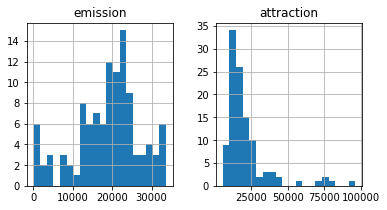

In [7]:
sm.zones[['emission', 'attraction']].hist(bins=20, figsize=(6,3))

In [8]:
# Now we need to introduce our demand segments.
# Car owners and PT captives is a good start.
# Other common demand segments are trip purposes, income groups, age groups.
sm.segments = ['car_owner', 'pt_captive']
car_ownership = 0.4
sm.zones[('car_owner', 'emission')] = sm.zones['emission'] * car_ownership
sm.zones[('pt_captive', 'emission')] = sm.zones['emission'] * (1-car_ownership)
sm.zones[('car_owner', 'attraction')] = sm.zones['attraction'] * car_ownership
sm.zones[('pt_captive', 'attraction')] = sm.zones['attraction'] * (1-car_ownership)

In [9]:
# Cast columns to integer
sm.zones[('car_owner', 'emission')] = sm.zones[('car_owner', 'emission')].astype(int)
sm.zones[('car_owner', 'attraction')] = sm.zones[('car_owner', 'attraction')].astype(int)
sm.zones[('pt_captive', 'emission')] = sm.zones[('pt_captive', 'emission')].astype(int)
sm.zones[('pt_captive', 'attraction')] = sm.zones[('pt_captive', 'attraction')].astype(int)

In [ ]:
# Delete the non-segmented columns to prevent errors
del sm.zones['emission']
del sm.zones['attraction']
sm.zones.sample()

## Step distribution

Once we have emission and attraction, we want to know the volumes per OD-pair. We can use the `step_distribution` function from quetzal. It uses the doubly constrained distribution (no probabilistic Logit approach), which is an iterative process where emissions and attractions are matched so that, on average, the minimal resistance for the whole system is found. Talking about resistance: an important input parameter is the impedance matrix, giving resistances between every OD-pair. Resistance can be time, but also cost or other utility/disutility quantifications.

Calibration of this step (not performed in this toy model) requires to change emission and attraction values or the impedance matrix

In [12]:
# Now, we need an impedance matrix for car and PT, respectively.
# Use time as resistance value, but distance or cost are thinkable, too
car_imp_matrix = sm.car_los[['origin', 'destination', 'time']].set_index(
    ['origin','destination']).unstack()
# Assign a resistance for staying in the home cell
car_imp_matrix = car_imp_matrix.replace(0, 120)

In [13]:
car_imp_matrix.head(3)

time                                                    \
destination      zone_0      zone_1     zone_10     zone_100     zone_101   
origin                                                                      
zone_0       120.000000  345.094805  594.001019   909.610439  1272.460863   
zone_1       453.364845  120.000000  590.900251   724.657746  1084.386617   
zone_10      473.296292  534.942233  120.000000  1025.358508  1388.934309   

                                                                             \
destination    zone_102     zone_103     zone_104     zone_105     zone_106   
origin                                                                        
zone_0       920.919327   999.893955   899.870637   970.896965  1116.345791   
zone_1       819.532189   844.216620   744.193302   791.820512  1031.000105   
zone_10      956.706673  1110.809737  1010.786419  1081.812747  1152.133137   

             ...                                                    \
destination  ...     zone_90     zone_91      zone_92      zone_93   
origin       ...                                                     
zone_0       ...  792.491377  824.128224   867.700414   889.170870   
zone_1       ...  620.921896  651.723997   679.626168   701.096624   
zone_10      ...  904.681988  936.318835  1003.646044  1031.420293   

                                                                              \
destination      zone_94      zone_95      zone_96      zone_97      zone_98   
origin                                                                         
zone_0        888.754446   984.367383  1098.909012   926.193513  1077.822567   
zone_1        700.680200   796.293137   943.231677   738.119267   889.748321   
zone_10      1005.227892  1100.840830  1209.824794  1042.666959  1194.296013   

                          
destination      zone_99  
origin                    
zone_0       1050.928756  
zone_1        862.854510  
zone_10      1167.402202  

[3 rows x 110 columns]

In [14]:
# In the PT case we have to take the minimum time per OD pair,
# because we have multiple routes
pt_imp_matrix = sm.pt_los.groupby(
    ['origin', 'destination']).agg({'time': 'min'}).unstack()

In [15]:
pt_imp_matrix = pt_imp_matrix.replace(0, 120)
pt_imp_matrix.head(3)

time                                                      \
destination      zone_0       zone_1      zone_10     zone_100     zone_101   
origin                                                                        
zone_0       120.000000   544.300764   884.563368  1294.743006  1624.211268   
zone_1       544.300764   120.000000  1011.942600  1193.061995  1554.463404   
zone_10      934.884236  1023.200088   120.000000  1568.884842  1827.853104   

                                                                              \
destination     zone_102     zone_103     zone_104     zone_105     zone_106   
origin                                                                         
zone_0       1335.216587  1542.538550  1400.170353  1295.739074  1284.478404   
zone_1       1259.968723  1394.492180  1298.489341  1158.538774  1209.230540   
zone_10      1581.858423  1770.315027  1674.312188  1534.361621  1531.120240   

             ...                                                      \
destination  ...      zone_90      zone_91      zone_92      zone_93   
origin       ...                                                       
zone_0       ...  1260.758607  1128.505779  1429.816024  1515.388510   
zone_1       ...  1207.771234  1131.500427  1415.568160  1440.140646   
zone_10      ...  1417.094082  1417.647615  1712.457860  1632.030346   

                                                                              \
destination      zone_94      zone_95      zone_96      zone_97      zone_98   
origin                                                                         
zone_0       1261.141616  1349.711548  1410.307053  1373.466102  1621.724742   
zone_1       1231.393752  1319.963684  1308.626042  1271.785090  1520.043731   
zone_10      1528.283452  1616.853384  1684.448889  1647.607937  1895.866578   

                          
destination      zone_99  
origin                    
zone_0       1505.230834  
zone_1       1475.482970  
zone_10      1694.435611  

[3 rows x 110 columns]

In [16]:
# We can perform the quetzal distribution function for all
# our demand segments simultaniously, saving us post-processing.
# Therefore, we need a dictionary with all parameters
distr_params = {'deterrence_matrix': {'car_owner': car_imp_matrix,
                                      'pt_captive': pt_imp_matrix}}
sm.step_distribution(segmented=True, **distr_params)

car_owner
pt_captive


In [17]:
sm.volumes.head(3)

,origin,destination,car_owner,pt_captive,all
0,zone_0,zone_0,0.087208,0.088690,0.175898
1,zone_0,zone_1,1.451771,2.141074,3.592845
2,zone_0,zone_2,1.355891,1.961368,3.317259


## Step mode choice

For mode choice we apply a nested logit model. In modeling terms, this step can be understood as the "logit" step, because the resulting utilities could also be used to compute the impedance matrix from above. You will see, that the logit step is entirely independent of the volumes and could, thus, be done earlier.

In [18]:
# First, we need parameters for our logit model.
# We define the nesting structure (i.e. choice tree)
# and the beta parameters which should come from a calibration
# using a mobility survey.
sm.preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
)
# For nest parameters you should take 1 >= mode >= pt_mode >= pt_path > 0

In [19]:
# Now we have generated the nesting structure table
# Can differ by demand segment, if you want
sm.mode_nests

segment,root,car_owner,pt_captive
route_type,,,
tram,pt,pt,pt
root,NaN,NaN,NaN
subway,pt,pt,pt
car,root,root,root
rail,pt,pt,pt
walk,root,root,root
bus,pt,pt,pt
pt,root,root,root


In [20]:
# And the corresponding theta values
sm.logit_scales

segment,root,car_owner,pt_captive
route_type,,,
tram,0.1,0.1,0.1
root,1.0,1.0,1.0
subway,0.1,0.1,0.1
car,0.0,0.0,0.0
rail,0.1,0.1,0.1
walk,0.0,0.0,0.0
bus,0.1,0.1,0.1
pt,0.5,0.5,0.5


In [21]:
# And the Alternative-Specific-Constants (ASC)
# We have to prevent PT captives from using a car
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility

segment,root,car_owner,pt_captive
route_type,,,
tram,0,0,0
root,0,0,0
subway,0,0,0
car,0,0,-100
rail,0,0,0
walk,0,0,0
bus,0,0,0


In [22]:
# And the beta parameters
# The column 'mode_utility' refers to the weight of the ASC table
# Delete the transfers attribute because we don't want it in our model formulation
sm.utility_values.drop('ntransfers', inplace=True)
sm.utility_values

segment,root,car_owner,pt_captive
value,,,
time,-0.00055,-0.00055,-0.00055
price,-1.00000,-1.00000,-1.00000
mode_utility,1.00000,1.00000,1.00000


In [23]:
# Now, add segment specific ASC column to LoS table.
# But first we have to generate a combined LoS table
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['route_types'] = sm.los['route_types'].apply(tuple)# bugfix
sm.analysis_mode_utility(how='main', # how refers to how to calculate the ASC from multiple paths
                         segment=None) # automatically iterates through segments

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.44it/s]


In [24]:
# Finally, run the logit model
sm.initialize_logit()
# If you want to know what parameters you can give to the function,
# look into the code. You can find the most important functions in
# the quetzal/model/transportmodel.py file, which refers to sub-functions
# by importing them from other quetzal files
sm.step_logit()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.67it/s]


In [25]:
# The result is a utilities table
sm.utilities.head(3)

route_type,origin,destination,segment,root,walk,car,pt,bus,rail,subway,tram
0,zone_1,zone_0,car_owner,-0.457201,-inf,-0.485126,-4.049365,-4.049365,-inf,-inf,-inf
1,zone_1,zone_0,pt_captive,-4.049365,-inf,-100.485126,-4.049365,-4.049365,-inf,-inf,-inf
2,zone_1,zone_1,car_owner,0.023245,-inf,0.000000,-3.750000,-3.750000,-inf,-inf,-inf


In [26]:
# and the probabilities
sm.probabilities.head(3)

route_type,origin,destination,segment,root,walk,car,pt,bus,rail,subway,tram
0,zone_1,zone_0,car_owner,1,0.0,9.724613e-01,0.027539,0.027539,0.0,0.0,0.0
1,zone_1,zone_0,pt_captive,1,0.0,1.313654e-42,1.000000,1.000000,0.0,0.0,0.0
2,zone_1,zone_1,car_owner,1,0.0,9.770226e-01,0.022977,0.022977,0.0,0.0,0.0


In [27]:
# Moreover, you have now probabilities assigned to your paths!
sm.los.head(3)

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,access_length,footpath_length,in_vehicle_length,length,price,mode_utility,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)"
0,zone_0,zone_0,0.000000,[zone_0],False,mode_breaker,"[tram, subway, bus, rail]",[],[],[],...,0.000000,0.000000,0.0,0.000000,3.75,0,-3.750000,-3.750000,0.022977,1.000000
1,zone_0,zone_1,544.300764,"[zone_0, n_11, zone_1]",False,mode_breaker,"[tram, subway, bus, rail]",[],[],[n_11],...,514.361614,0.000000,0.0,514.361614,3.75,0,-4.049365,-4.049365,0.023584,1.000000
2,zone_0,zone_10,1598.389713,"[zone_0, n_27, n_58, zone_10]",False,mode_breaker,"[tram, subway, bus, rail]",[],[],"[n_27, n_58]",...,1241.691508,629.762057,0.0,1871.453565,3.75,0,-4.629114,-4.629114,0.000374,0.009956


## Step assignment

This step combines the path probabilities with the volumes and loads them onto the networks.

In [28]:
sm.volumes.head(2)

,origin,destination,car_owner,pt_captive,all
0,zone_0,zone_0,0.087208,0.088690,0.175898
1,zone_0,zone_1,1.451771,2.141074,3.592845


In [29]:
# We want to do an assignment for cars and PT seperately
# (although there is a wrapper function in quetzal)
# Therefore, we must transfer the path probabilities to pt_los and car_los
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']

In [30]:
# PT first
sm.segmented_pt_assignment(split_by='route_type', # identify from which route type the load comes
                           on_road_links=False, # load bus traffic to the road network (requires casted networks)
                           path_column='link_path' # pt_los column with the path list
                          )

pt_captive: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.06s/it]


In [31]:
# Now cars
sm.segmented_car_assignment()

pt_captive: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


In [32]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,...,duration,cost,origin,destination,geometry,"(load, bus)","(load, tram)","(load, subway)","(load, rail)",load
index,,,,,,,,,,,,,,,,,,,,,
link_3100,100100088:88_0,n_82,n_8,18,120.0,450,100100088:88_0,100100088:88,8032,0,...,120.0,345.0,n_82,n_8,"LINESTRING (2.26493 48.84109, 2.26063 48.84304)",15.67209,60.767272,0.0,51.809472,128.248834


In [33]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,length,time,walk_time,geometry,highway,"(car_owner, car)","(pt_captive, car)","(all, car)"
index,,,,,,,,,,
19878,25199592,470165,122.352,15.968235,47.904705,"LINESTRING (2.31324 48.86105, 2.31311 48.85995)",primary,15807.335888,2.279115e-38,15807.335888


<AxesSubplot:>

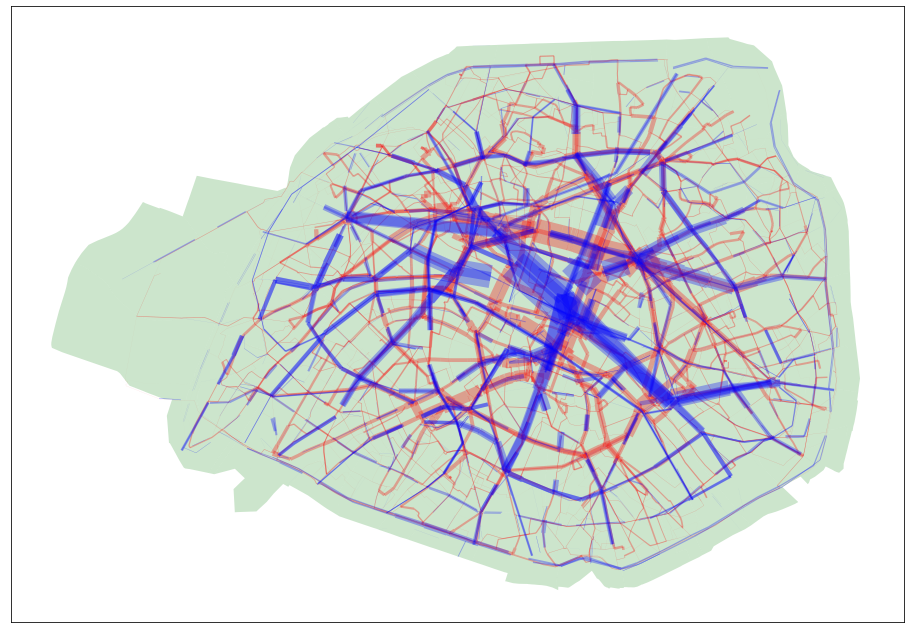

In [34]:
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

In [35]:
# Summary of LoS table using a quetzal function
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # seconds per ride
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per ride

In [36]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'time')] = od_sum[(seg, 'time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

In [37]:
od_sum.sample(3)

segment                   car_owner                                      \
sum                          volume     price      time in_vehicle_time   
origin  destination mode                                                  
zone_86 zone_32     car   91.965030  0.861799  0.297565        0.000000   
zone_54 zone_19     tram   0.231037  0.005195  0.000607        0.000260   
zone_75 zone_97     tram   0.002561  0.000096  0.000039        0.000018   

segment                                          pt_captive                \
sum                         length ntransfers        volume         price   
origin  destination mode                                                    
zone_86 zone_32     car   7.181662   0.000000  7.409431e-41  5.189854e-43   
zone_54 zone_19     tram  0.013998   0.003117  8.059823e+00  1.122754e-01   
zone_75 zone_97     tram  0.000454   0.000019  1.827060e-01  4.714540e-03   

segment                                                 ...             \
sum                               time in_vehicle_time  ... ntransfers   
origin  destination mode                                ...              
zone_86 zone_32     car   1.791970e-43        0.000000  ...   0.000000   
zone_54 zone_19     tram  1.312613e-02        0.005614  ...   0.067365   
zone_75 zone_97     tram  1.928544e-03        0.000880  ...   0.000943   

segment                        root                                      \
sum                          volume     price      time in_vehicle_time   
origin  destination mode                                                  
zone_86 zone_32     car   91.965030  0.861799  0.297565        0.000000   
zone_54 zone_19     tram   8.290860  0.109291  0.012777        0.005465   
zone_75 zone_97     tram   0.185267  0.004651  0.001902        0.000868   

segment                                         car_owner    pt_captive  \
sum                         length ntransfers         pkm           pkm   
origin  destination mode                                                  
zone_86 zone_32     car   7.181662   0.000000  660.461801  3.204489e-82   
zone_54 zone_19     tram  0.294489   0.065575    0.003234  2.438329e+00   
zone_75 zone_97     tram  0.022071   0.000930    0.000001  4.087813e-03   

segment                         root  
sum                              pkm  
origin  destination mode              
zone_86 zone_32     car   660.461801  
zone_54 zone_19     tram    2.441564  
zone_75 zone_97     tram    0.004089  

[3 rows x 21 columns]

array([<AxesSubplot:ylabel='(car_owner, volume)'>,
       <AxesSubplot:ylabel='(pt_captive, volume)'>], dtype=object)

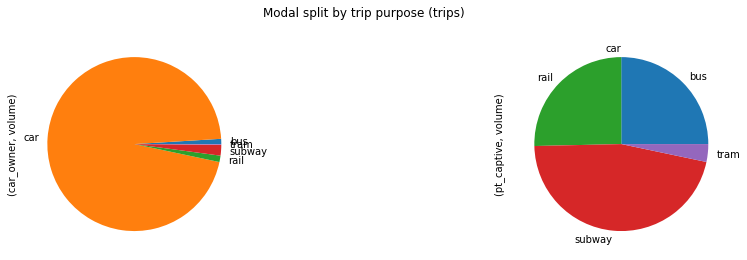

In [38]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='(car_owner, pkm)'>,
       <AxesSubplot:ylabel='(pt_captive, pkm)'>], dtype=object)

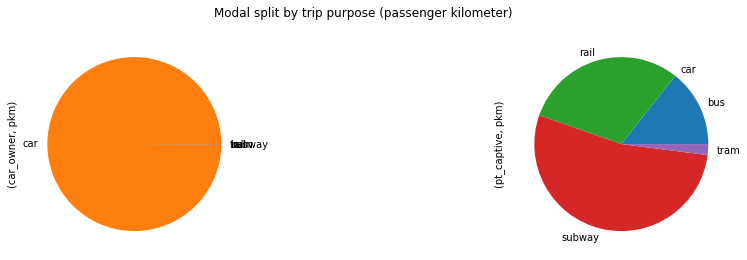

In [39]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

## Save model

In [40]:
# Save the od_sum as Excel
with pd.ExcelWriter('../../outputs/od_summary.xlsx') as writer:  
    od_sum.to_excel(writer, sheet_name='od_sum')

In [41]:
# make sure that all tables have unique indicies before saving
sm.probabilities.reset_index(inplace=True, drop=True)
sm.utilities.reset_index(inplace=True, drop=True)

In [42]:
sm.to_json(model_path + 'four_steps')

to_hdf(overwriting):  71%|███████████████████████████████████████████▍                 | 32/45 [00:35<00:07,  1.66it/s]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 45/45 [00:46<00:00,  1.04s/it]

could not save attribute: parameters
